In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import torchvision
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, scale

from itertools import product

from helpers import load_data
from mlp import MLP

%matplotlib inline

In [2]:
batch_size = 64

train, test = load_data('data/train.csv', test_size=0.2, standardize=True)

# data loaders
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

C:\Users\Mariko\Anaconda3\envs\py3.7\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mariko\Anaconda3\envs\py3.7\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [3]:
def train(model, train_loader, test_loader, optimizer, nb_epochs=10, verbose=True):
    train_losses = []
    train_counter = []
    test_accuracy = []
    criterion = nn.NLLLoss()
    
    for epoch in range(nb_epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 50 == 0 and verbose:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append((batch_idx*batch_size) + (epoch*len(train_loader.dataset)))
        test_accuracy.append(test(model, test_loader))
    return train_losses, train_counter, test_accuracy

In [4]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    # test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    
    return accuracy

In [ ]:
nb_epochs = 10
lr = 0.01

In [ ]:
model = MLP()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train_losses, train_counter = train(model, train_loader, optimizer, nb_epochs)

In [5]:
def train_average_sgd(train_loader, test_loader, lr=0.01, momentum=0.9, nb_models=10, nb_epochs=10):
    all_train_losses = []
    train_counter = []
    for i in range(nb_models):
        print('Training model %d...' % i)
        model = MLP()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        train_losses, train_counter, test_accuracy = train(
            model, train_loader, test_loader, optimizer, nb_epochs, verbose=False)
        all_train_losses.append(train_losses)
    return np.mean(all_train_losses, axis=0), train_counter, test_accuracy

In [ ]:
lrs = [0.01, 0.05, 0.1]
momentums = [0.5, 0.7, 0.9]

params = list(product(*[lrs, momentums]))
grid_search_losses_sgd = dict()
grid_search_accuracy_sgd = dict()

for lr, momentum in params:
    label = 'lr: ' + str(lr) + ' m: ' + str(momentum)
    print('Model with', label)
    train_losses, train_counter, test_accuracy = train_average_sgd(
        train_loader, test_loader, lr=lr, momentum=momentum, nb_models=3, nb_epochs=10)
    grid_search_losses_sgd[label] = train_losses
    grid_search_accuracy_sgd[label] = test_accuracy

In [ ]:
color = iter(plt.get_cmap('tab10')(np.linspace(0,1,10)))
plt.figure(figsize=(14, 8))
for k, v in grid_search_losses_sgd.items():
    plt.plot(train_counter, v, label=k, color=next(color))
plt.legend()
plt.show()

In [ ]:
color = iter(plt.get_cmap('tab10')(np.linspace(0,1,10)))
plt.figure(figsize=(14, 8))
for k, v in grid_search_accuracy_sgd.items():
    plt.plot(train_counter, v, label=k, color=next(color))
plt.legend()
plt.grid()
plt.show()

In [6]:
def train_average_rmsprop(train_loader, test_loader, lr=0.01, alpha=0.99, momentum=0, eps=1e-8, nb_models=10, nb_epochs=10):
    all_train_losses = []
    train_counter = []
    for i in range(nb_models):
        print('Training model %d...' % i)
        model = MLP()
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, momentum=momentum, alpha=alpha, eps=eps)
        train_losses, train_counter, test_accuracy = train(
            model, train_loader, test_loader, optimizer, nb_epochs, verbose=False)
        all_train_losses.append(train_losses)
    return np.mean(all_train_losses, axis=0), train_counter, test_accuracy

In [ ]:
lrs = [0.001, 0.01]
momentums = [0., 1e-4]
alphas = [0.9, 0.99, 0.999]

params = list(product(*[lrs, momentums, alphas]))
grid_search_losses_rmsprop = dict()
grid_search_accuracy_rmsprop = dict()

for lr, momentum, alpha in params:
    label = 'lr: ' + str(lr) + ' m: ' + str(momentum) + ' alpha: ' + str(alpha)
    print('Model with', label)
    train_losses, train_counter, test_accuracy = train_average_rmsprop(
        train_loader, test_loader, lr=lr, momentum=momentum, alpha=alpha, nb_models=3, nb_epochs=10)
    grid_search_losses_rmsprop[label] = train_losses
    grid_search_accuracy_rmsprop[label] = test_accuracy

In [ ]:
color = iter(plt.get_cmap('tab10')(np.linspace(0,1,12)))
plt.figure(figsize=(14, 8))
for k, v in grid_search_losses_rmsprop.items():
    plt.plot(train_counter, v, label=k, color=next(color))
plt.legend()
plt.show()

In [7]:
def train_average_adam(train_loader, test_loader, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8, nb_models=10, nb_epochs=10):
    all_train_losses = []
    train_counter = []
    for i in range(nb_models):
        print('Training model %d...' % i)
        model = MLP()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta1, beta2), eps=eps)
        train_losses, train_counter, test_accuracy = train(model, train_loader, test_loader,
                                                           optimizer, nb_epochs, verbose=False)
        all_train_losses.append(train_losses)
    return np.mean(all_train_losses, axis=0), train_counter, test_accuracy

In [ ]:
lrs = [1e-4, 1e-3, 1e-2]
beta1s = [0.9, 0.99]
beta2s = [0.99, 0.999]
# adam configuration parameter tips https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

params = list(product(*[lrs, beta1s, beta2s]))
grid_search_losses_adam = dict()
grid_search_accuracy_adam = dict()

for lr, beta1, beta2 in params:
    label = 'lr: ' + str(lr) + ' beta1: ' + str(beta1) + ' beta2: ' + str(beta2)
    print('Model with', label)
    train_losses, train_counter, test_accuracy = train_average_adam(
        train_loader, test_loader, lr=lr, beta1=beta1, beta2=beta2, nb_models=3, nb_epochs=10)
    grid_search_losses_adam[label] = train_losses
    grid_search_accuracy_adam[label] = test_accuracy

In [ ]:
color = iter(plt.get_cmap('tab10')(np.linspace(0,1,12)))
plt.figure(figsize=(14, 8))
for k, v in grid_search_losses_adam.items():
    plt.plot(train_counter, v, label=k, color=next(color))
plt.legend()
plt.show()

In [8]:
def train_average_adadelta(train_loader, test_loader, lr=1.0, rho=0.9, eps=1e-6, nb_models=10, nb_epochs=10):
    all_train_losses = []
    train_counter = []
    for i in range(nb_models):
        print('Training model %d...' % i)
        model = MLP()
        optimizer = torch.optim.Adadelta(model.parameters(), lr=lr, rho=rho, eps=eps)
        train_losses, train_counter, test_accuracy = train(model, train_loader, test_loader,
                                                           optimizer, nb_epochs, verbose=False)
        all_train_losses.append(train_losses)
    return np.mean(all_train_losses, axis=0), train_counter, test_accuracy

In [ ]:
lrs = [0.9, 1.]
rhos = [0.9, 0.95, 0.99]

params = list(product(*[lrs, rhos]))
grid_search_losses_adadelta = dict()
grid_search_accuracy_adadelta = dict()

for lr, rho in params:
    label = 'lr: ' + str(lr) + ' rho: ' + str(rho)
    print('Model with', label)
    train_losses, train_counter = train_average_adadelta(
        train_loader, test_loader, lr=lr, rho=rho, nb_models=3, nb_epochs=10)
    grid_search_losses_adadelta[label] = train_losses
    grid_search_accuracy_adadelta[label] = test_accuracy

In [ ]:
color = iter(plt.get_cmap('tab10')(np.linspace(0,1,8)))
plt.figure(figsize=(14, 8))
for k, v in grid_search_losses_adadelta.items():
    plt.plot(train_counter, v, label=k, color=next(color))
plt.legend()
plt.show()

In [10]:
nb_models = 10
nb_epochs = 10

optimizers_default = {
    'sgd': train_average_sgd(train_loader, test_loader, nb_models=nb_models, nb_epochs=nb_epochs),
    'rmsprop': train_average_rmsprop(train_loader, test_loader, nb_models=nb_models, nb_epochs=nb_epochs),
    'adam': train_average_adam(train_loader, test_loader, nb_models=nb_models, nb_epochs=nb_epochs),
    'adadelta': train_average_adadelta(train_loader, test_loader, nb_models=nb_models, nb_epochs=nb_epochs)
}

Training model 0...


C:\Users\Mariko\Courses\OptML\mlp.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Training model 1...
Training model 2...
Training model 3...
Training model 4...
Training model 5...
Training model 6...
Training model 7...
Training model 8...
Training model 9...
Training model 0...
Training model 1...
Training model 2...
Training model 3...
Training model 4...
Training model 5...
Training model 6...
Training model 7...
Training model 8...
Training model 9...
Training model 0...
Training model 1...
Training model 2...
Training model 3...
Training model 4...
Training model 5...
Training model 6...
Training model 7...
Training model 8...
Training model 9...
Training model 0...
Training model 1...
Training model 2...
Training model 3...
Training model 4...
Training model 5...
Training model 6...
Training model 7...
Training model 8...
Training model 9...


In [ ]:
# optimizers_best = {
#     'sgd': train_average_sgd(train_loader, lr=0.1, momentum=0.5, nb_models=nb_models, nb_epochs=nb_epochs),
#     'rmsprop': train_average_rmsprop(train_loader, lr=0.001, momentum=0.0001, alpha=0.999, 
#                                      nb_models=nb_models, nb_epochs=nb_epochs),
#     'adam': train_average_adam(train_loader, lr=0.001, beta1=0.9, beta2=0.999, nb_models=nb_models,
#                                nb_epochs=nb_epochs),
#     'adadelta': train_average_adadelta(train_loader, lr=1.0, rho=0.95, nb_models=nb_models, nb_epochs=nb_epochs)
# }

In [11]:
losses_optimizers = dict()
accuracy_optimizers = dict()

for k, v in optimizers_default.items():
    train_losses, train_counter, test_accuracy = v
    losses_optimizers[k] = train_losses
    accuracy_optimizers[k] = test_accuracy

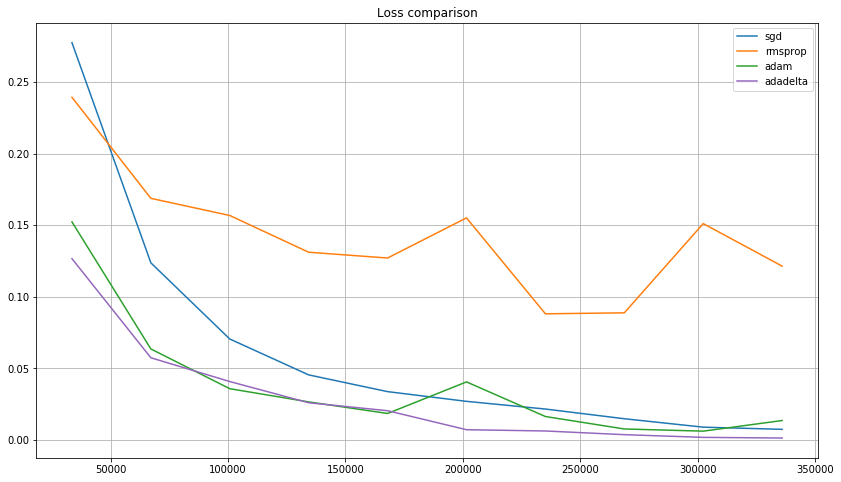

In [12]:
color = iter(plt.get_cmap('tab10')(np.linspace(0,1,8)))
plt.figure(figsize=(14, 8))
for k, v in losses_optimizers.items():
    plt.plot(train_counter, v, label=k, color=next(color))
plt.legend()
plt.grid()
plt.title('Loss comparison')
plt.show()

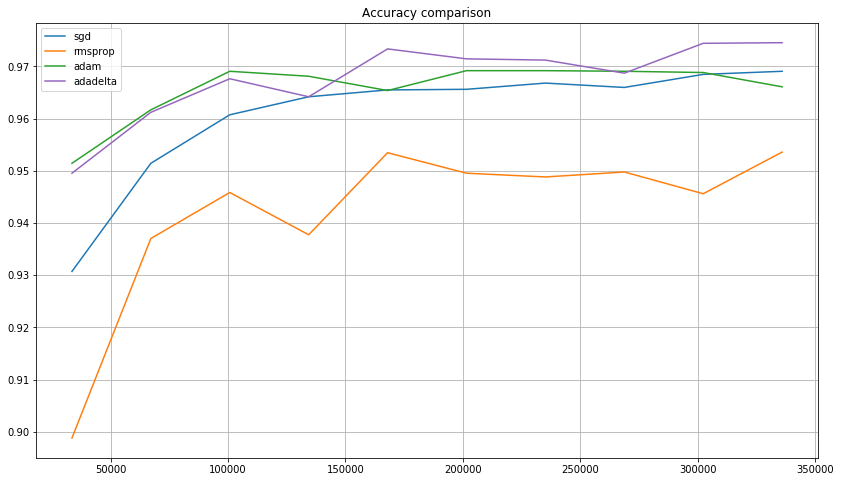

In [14]:
color = iter(plt.get_cmap('tab10')(np.linspace(0,1,8)))
plt.figure(figsize=(14, 8))
for k, v in accuracy_optimizers.items():
    plt.plot(train_counter, v, label=k, color=next(color))
plt.legend()
plt.grid()
plt.title('Accuracy comparison')
plt.show()

In [ ]:
# adabound